In [3]:
import numpy as np
import scipy as sp
import torch
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys
import cvxpy as cp
from itertools import product
sys.path.insert(0, os.path.abspath('../../'))

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import dense_to_sparse

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Solver

In [5]:
def ipm(n_features, mask, max_iter, data, y, verbose, lambda_=1.0e-6):

## Changed to CVX to get better accuracy because simple GD sucks.
    n = len(y[mask])
    w = cp.Variable(n_features + 1) 
    log_likelihood = -lambda_*cp.sum_squares(w) + (cp.sum(cp.multiply(y[mask], (data @ w)[mask]) - cp.logistic((data @ w)[mask])))/n
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.norm(w[0:n_features],2) <= n_features]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose = verbose, reltol=1.0e-10, abstol=1.0e-10, max_iters=max_iter)
    
    return w.value

## Plot function

In [6]:
def plot_(all_results,x_axis_class,name,n_classes):

    for class_ in range(n_classes):
        
        print("Plot for class: ", chr(65 + class_))

        train_obj_without_graph = all_results[class_][0]
        train_obj_with_graph = all_results[class_][1]
        train_error_without_graph = all_results[class_][2]
        train_error_with_graph = all_results[class_][3]
        test_obj_without_graph = all_results[class_][4]
        test_obj_with_graph = all_results[class_][5]
        test_error_without_graph = all_results[class_][6]
        test_error_with_graph = all_results[class_][7]
        x_axis_class = x_axis[class_]

        fig = plt.figure(figsize=(20,10), facecolor=[1,1,1])
        linestyles = ['-','--',':','-.']
        markers = ['v', 's', '*', 'D']

        ax = fig.add_subplot(1, 1, 1)
        ax.plot(x_axis_class, test_error_without_graph, linewidth=7, linestyle= '--', marker='o', markersize=20, label='Without graph conv.')
        ax.plot(x_axis_class, test_error_with_graph, linewidth=7, linestyle= '--', marker='s', markersize=20, label='With graph conv.')    
        
        ax.set_xlabel(r'$\rho$', fontsize=50)
        ax.set_ylabel('Test error', fontsize=50)
        ax.legend(loc='lower right', fontsize=50)
        plt.xticks(fontsize=40)
        plt.yticks(fontsize=40)
        plt.yscale('linear')
        ax.grid()

        fig.savefig(name + "_class=" + str(class_) + ".pdf", bbox_inches='tight')
        plt.show()

## Generate data function

In [7]:
def generate_data(data, train_mask, test_mask, lambda_, factor, step_multiplier, n_classes = 2):

    all_results = {}
    x_axis = {}
    
    trials = 5

    for class_ in range(n_classes):
        y_ = idx = data.y.numpy()
        idx = y_ == class_
        y = np.zeros(len(y_), dtype=np.int)
        y[idx] = 1
        
        X_ = data.x.numpy()
        
        n = X_.shape[0]
        n_features = X_.shape[1]
                
        node_indices = np.asarray(range(0,n))
        C1 = node_indices[y == 0]
        C2 = node_indices[y == 1]

        np.sum(np.mean(X_[1-y,:],0))

        X = np.zeros((n,n_features+1))
        X[:,:-1] = X_
        X[:,-1]  = np.ones(n)
        
        alpha = np.sum(y[train_mask] == 0)/np.sum(y == 0)
        beta = np.sum(y[train_mask] == 1)/np.sum(y == 1)
        
        print("class:", chr(65 + class_), " n: ", n, " d: ", n_features, " d(mu,nu): ", np.linalg.norm(np.mean(X_[C1,:],0) - np.mean(X_[C2,:],0)), " alpha: ", alpha, " beta: ", beta)
        
#         print("& " + chr(65 + class_) + " & $"+ '{0:.1e}'.format(alpha) + "$ & $" + '{0:.1e}'.format(beta) + "$ & $" + '{0:.1e}'.format(np.linalg.norm(np.mean(X_[C1,:],0) - np.mean(X_[C2,:],0))) + "$")

        rows = data.edge_index[0].numpy() 
        cols = data.edge_index[1].numpy()
        A = sp.sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(n, n))
        A.setdiag(A.diagonal() + 1)

        d_mat = np.sum(A, axis=0)
        dinv_mat = 1/d_mat
        d = d_mat.tolist()[0]
        dinv = dinv_mat.tolist()[0]
        D = sp.sparse.diags(d, 0)
        Dinv = sp.sparse.diags(dinv, 0)

        # Create data
        DAX_ = Dinv@A@X_

        # Append a column of ones for the coefficients of the bias
        DAX = np.zeros((n,n_features+1))
        DAX[:,:-1] = DAX_
        DAX[:,-1]  = np.ones(n)

        w = ipm(n_features, train_mask, 100, X, y, False, lambda_=lambda_)
        w_graph = ipm(n_features, train_mask, 100, DAX, y, False, lambda_=lambda_)

        B = A.todense().copy()

        B[C1,C1] = 1
        B[C2,C2] = 1

        new_rows = (1-B).nonzero()[0]
        new_cols = (1-B).nonzero()[1]

        max_how_many = new_rows.shape[0]

        n_cross_edges = np.long(y.T@A@(1-y))
        
        x_axis_class = np.asarray(range(0,np.long(factor*n_cross_edges),np.long(step_multiplier*n_cross_edges)))/n_cross_edges

        train_obj_without_graph = np.zeros(len(x_axis_class))
        train_obj_with_graph = np.zeros(len(x_axis_class))
        train_error_without_graph = np.zeros(len(x_axis_class))
        train_error_with_graph = np.zeros(len(x_axis_class))
        test_obj_without_graph = np.zeros(len(x_axis_class))
        test_obj_with_graph = np.zeros(len(x_axis_class))
        test_error_without_graph = np.zeros(len(x_axis_class))
        test_error_with_graph = np.zeros(len(x_axis_class))
        
        for trial in range(trials):
            
            perm_new_rows = np.random.permutation(new_rows)
            perm_new_cols = np.random.permutation(new_cols)

            for idx, how_many in enumerate(np.asarray(range(0,np.long(factor*n_cross_edges),np.long(step_multiplier*n_cross_edges)))):

                pick_from_new_rows = perm_new_rows[0:how_many]
                pick_from_new_cols = perm_new_cols[0:how_many]

                rows = np.append(data.edge_index[0].numpy(), pick_from_new_rows) 
                cols = np.append(data.edge_index[1].numpy(), pick_from_new_cols)

                A = sp.sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(n, n))
                A.setdiag(A.diagonal() + 1)

                d_mat = np.sum(A, axis=0)
                dinv_mat = 1/d_mat
                d = d_mat.tolist()[0]
                dinv = dinv_mat.tolist()[0]
                D = sp.sparse.diags(d, 0)
                Dinv = sp.sparse.diags(dinv, 0)

                DAX_ = Dinv@A@X_
                DAX = np.zeros((n,n_features+1))
                DAX[:,:-1] = DAX_
                DAX[:,-1]  = np.ones(n)

                sigma = 1/(1+np.exp(-X@w))
                sigma = sigma[train_mask]
                obj = np.sum(-y[train_mask]*np.log(sigma + 1.0e-12) - (1-y[train_mask])*np.log(1-sigma + 1.0e-12))/n
                pred_y_train = np.zeros(len(sigma))
                pred_y_train[sigma > 0.5] = 1
                error_train = np.linalg.norm(y[train_mask] - pred_y_train)**2/y[train_mask].shape[0]

                train_obj_without_graph[idx] += obj
                train_error_without_graph[idx] += error_train

                sigma = 1/(1+np.exp(-DAX@w_graph))
                sigma = sigma[train_mask]
                obj = np.sum(-y[train_mask]*np.log(sigma + 1.0e-12) - (1-y[train_mask])*np.log(1-sigma + 1.0e-12))/n
                pred_y_train = np.zeros(len(sigma))
                pred_y_train[sigma > 0.5] = 1
                error_train = np.linalg.norm(y[train_mask] - pred_y_train)**2/y[train_mask].shape[0]

                train_obj_with_graph[idx] += obj
                train_error_with_graph[idx] += error_train

                sigma = 1/(1+np.exp(-X@w))
                sigma = sigma[test_mask]
                obj = np.sum(-y[test_mask]*np.log(sigma + 1.0e-12) - (1-y[test_mask])*np.log(1-sigma + 1.0e-12))/n
                pred_y_train = np.zeros(len(sigma))
                pred_y_train[sigma > 0.5] = 1
                error_test = np.linalg.norm(y[test_mask] - pred_y_train)**2/y[test_mask].shape[0]

                test_obj_without_graph[idx] += obj
                test_error_without_graph[idx] += error_test

                sigma = 1/(1+np.exp(-DAX@w_graph))
                sigma = sigma[test_mask]
                obj = np.sum(-y[test_mask]*np.log(sigma + 1.0e-12) - (1-y[test_mask])*np.log(1-sigma + 1.0e-12))/n
                pred_y_train = np.zeros(len(sigma))
                pred_y_train[sigma > 0.5] = 1
                error_test = np.linalg.norm(y[test_mask] - pred_y_train)**2/y[test_mask].shape[0]

                test_obj_with_graph[idx] += obj
                test_error_with_graph[idx] += error_test
                
        train_obj_without_graph /= trials
        train_obj_with_graph /= trials
        train_error_without_graph /= trials
        train_error_with_graph /= trials
        test_obj_without_graph /= trials
        test_obj_with_graph /= trials
        test_error_without_graph /= trials
        test_error_with_graph /= trials

        all_results[class_] = [train_obj_without_graph,train_obj_with_graph,train_error_without_graph,train_error_with_graph,test_obj_without_graph,test_obj_with_graph,test_error_without_graph,test_error_with_graph]
        x_axis[class_] = x_axis_class
    return all_results, x_axis

## Cora

In [8]:
from torch_geometric.datasets import Planetoid

In [9]:
dataset = Planetoid(root='data/Cora/', name='Cora')
name = 'Cora'

Processing...
Done!


class: A  n:  2708  d:  1433  d(mu,nu):  0.7055702  alpha:  0.050912176495545185  beta:  0.05698005698005698
class: B  n:  2708  d:  1433  d(mu,nu):  0.94155115  alpha:  0.04817342432757928  beta:  0.09216589861751152
class: C  n:  2708  d:  1433  d(mu,nu):  0.9173762  alpha:  0.05240174672489083  beta:  0.04784688995215311
class: D  n:  2708  d:  1433  d(mu,nu):  0.6837755  alpha:  0.06349206349206349  beta:  0.02444987775061125
class: E  n:  2708  d:  1433  d(mu,nu):  0.76898074  alpha:  0.05258545135845749  beta:  0.046948356807511735
class: F  n:  2708  d:  1433  d(mu,nu):  0.84995985  alpha:  0.04979253112033195  beta:  0.06711409395973154
class: G  n:  2708  d:  1433  d(mu,nu):  0.85928136  alpha:  0.04746835443037975  beta:  0.1111111111111111
Plot for class:  A


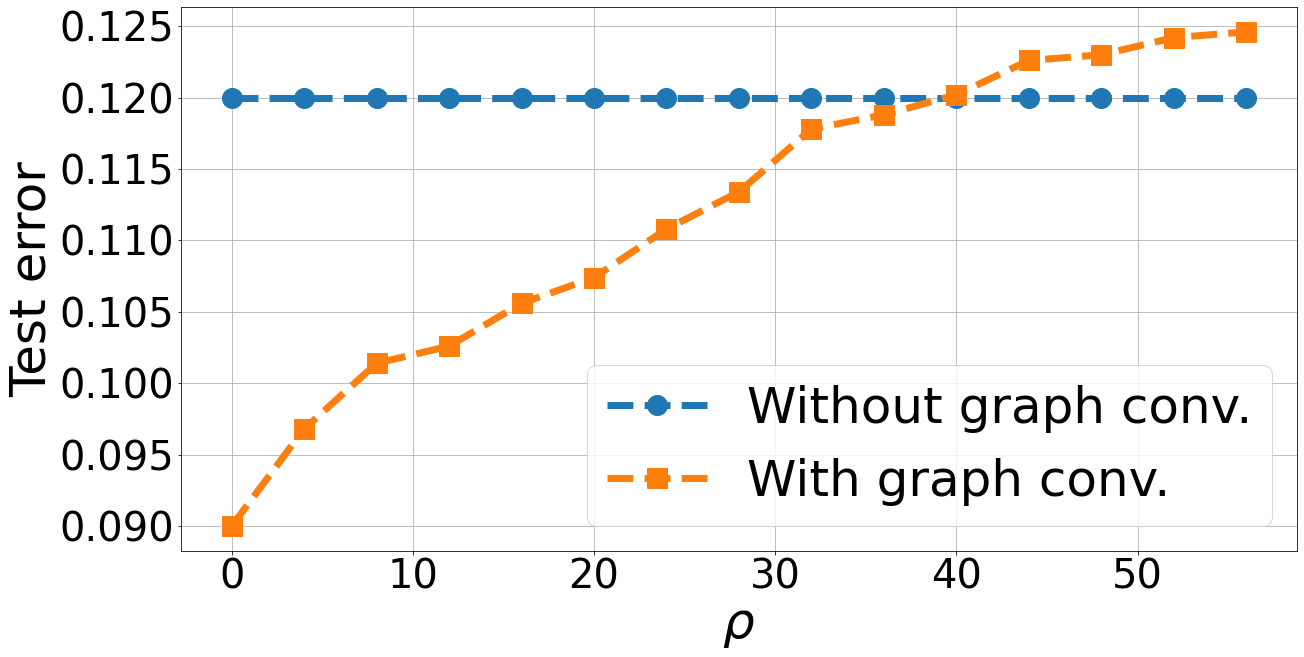

Plot for class:  B


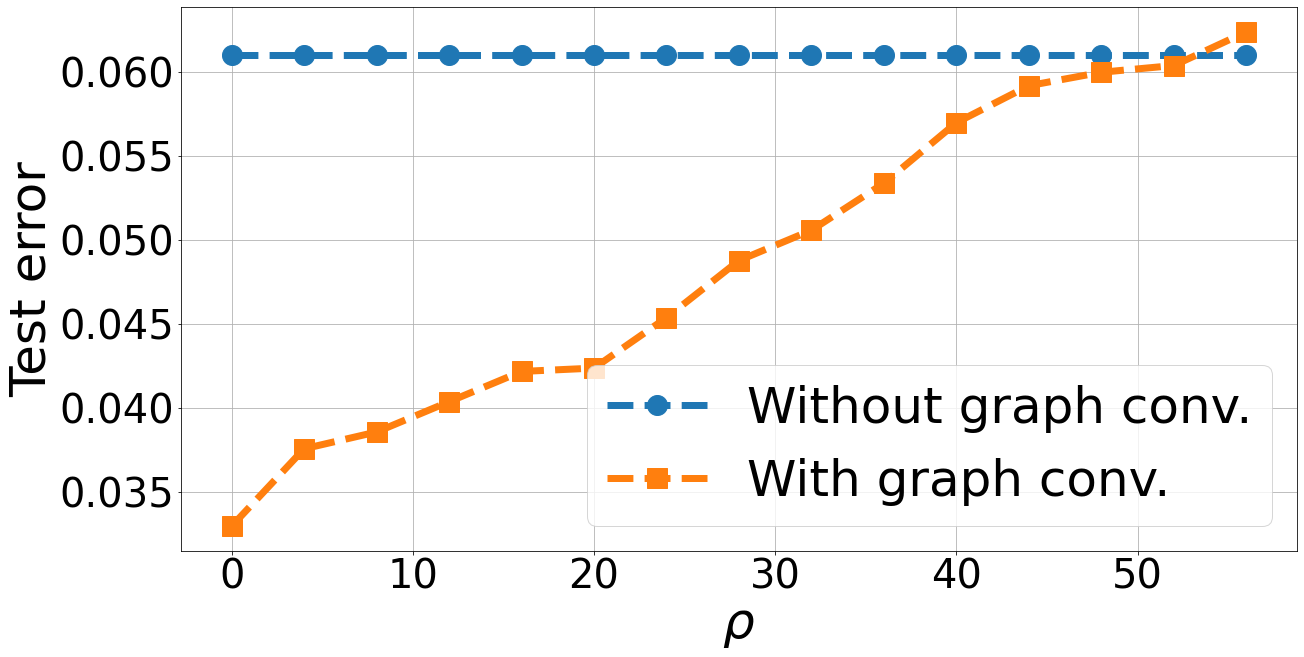

Plot for class:  C


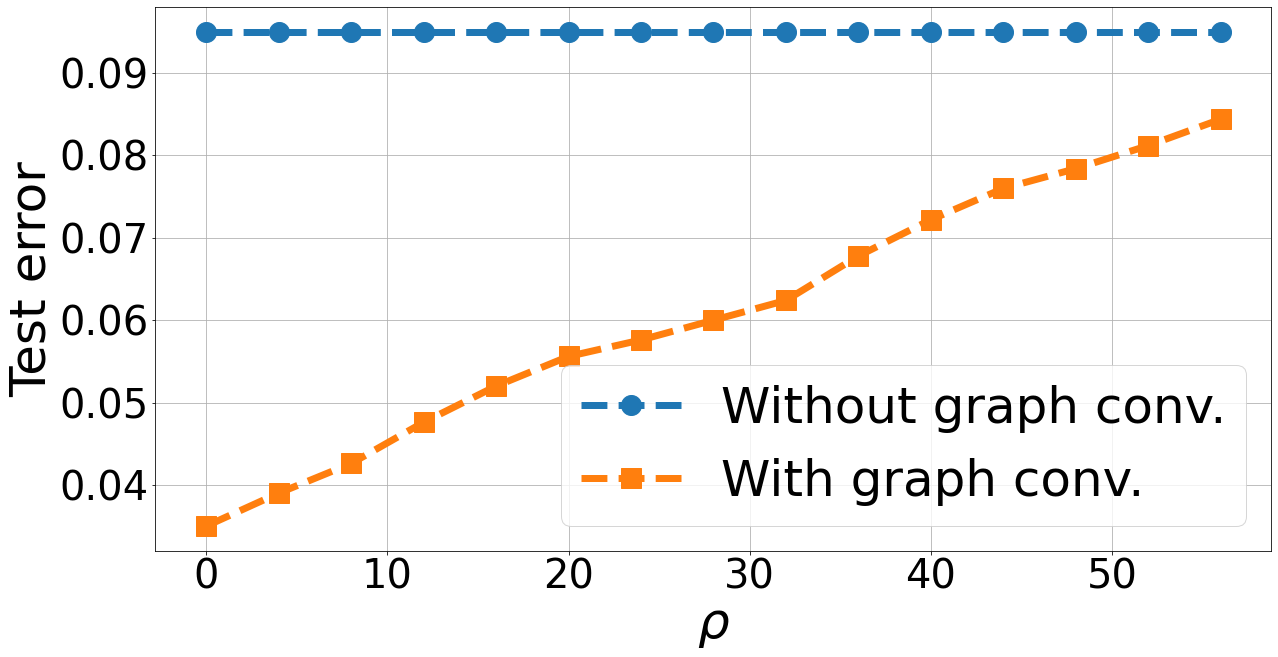

Plot for class:  D


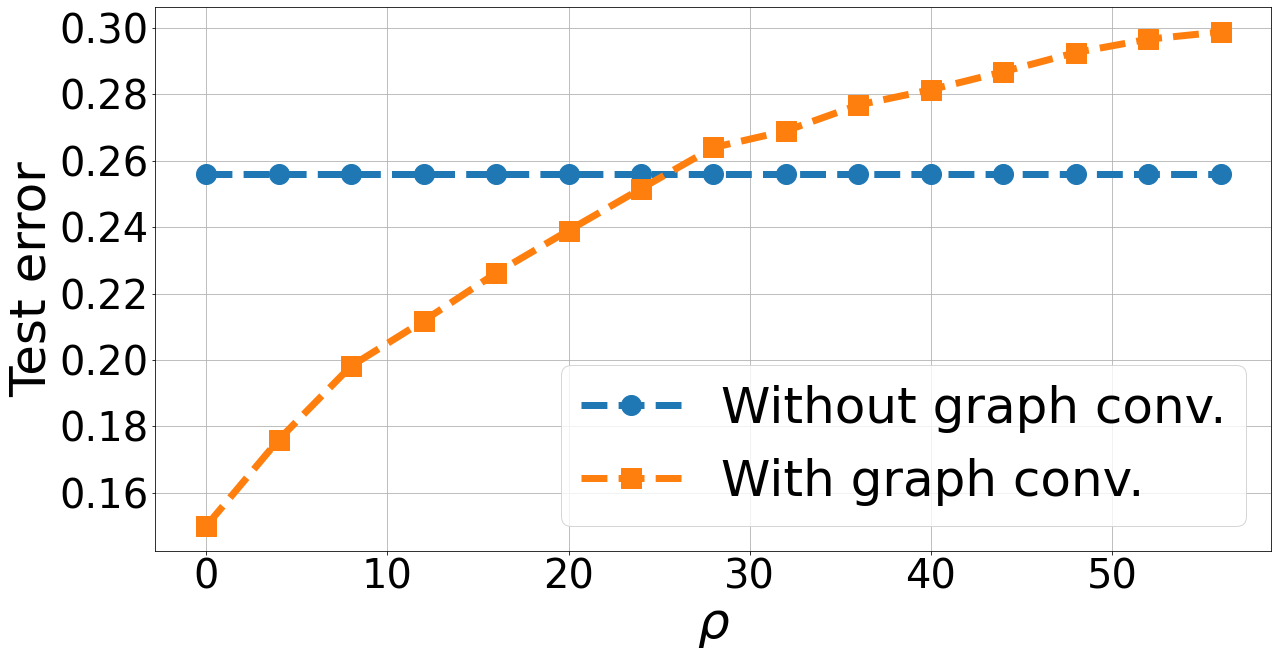

Plot for class:  E


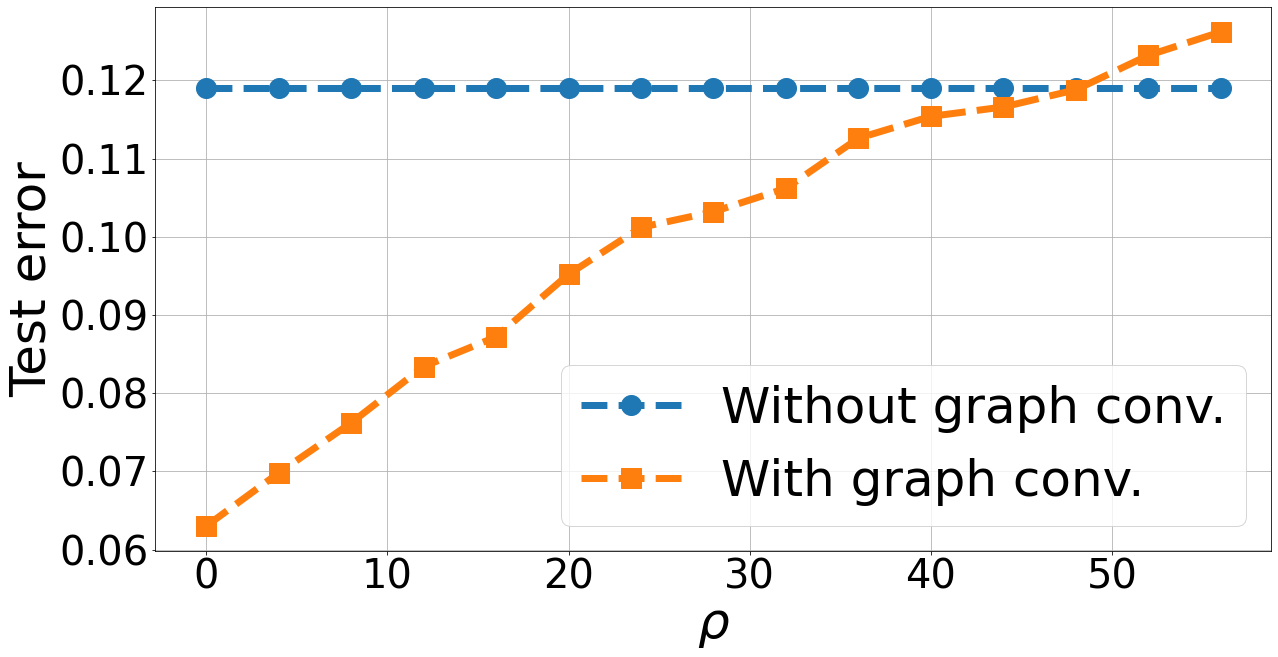

Plot for class:  F


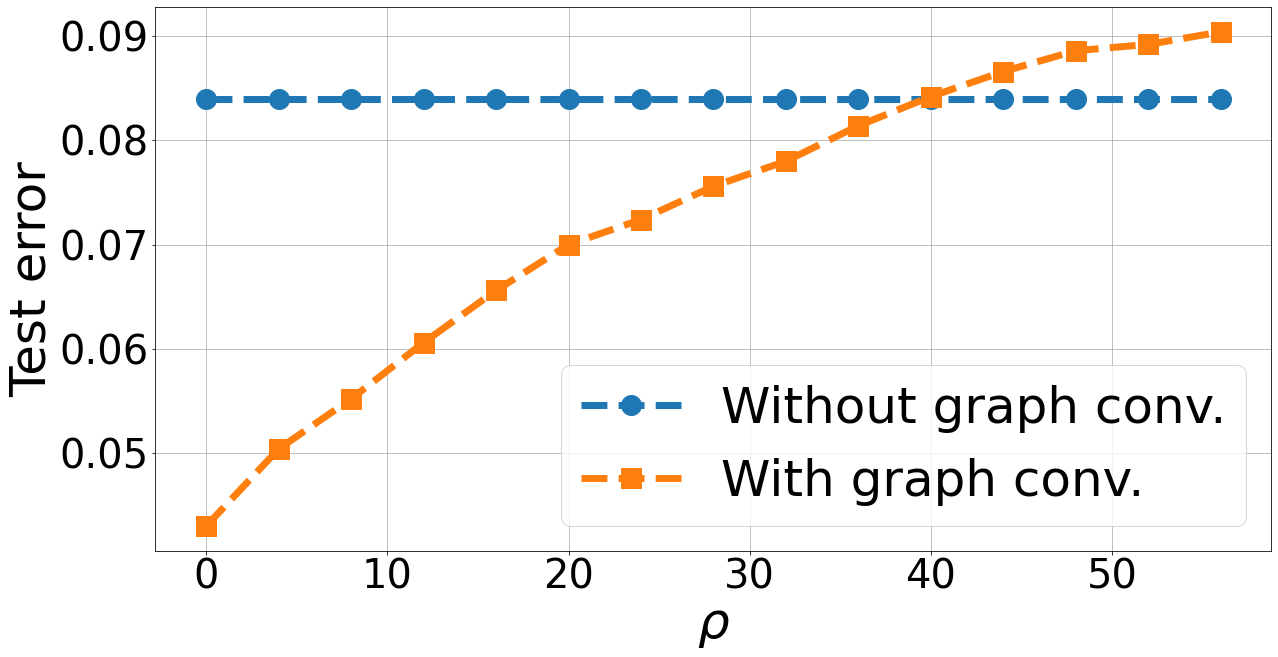

Plot for class:  G


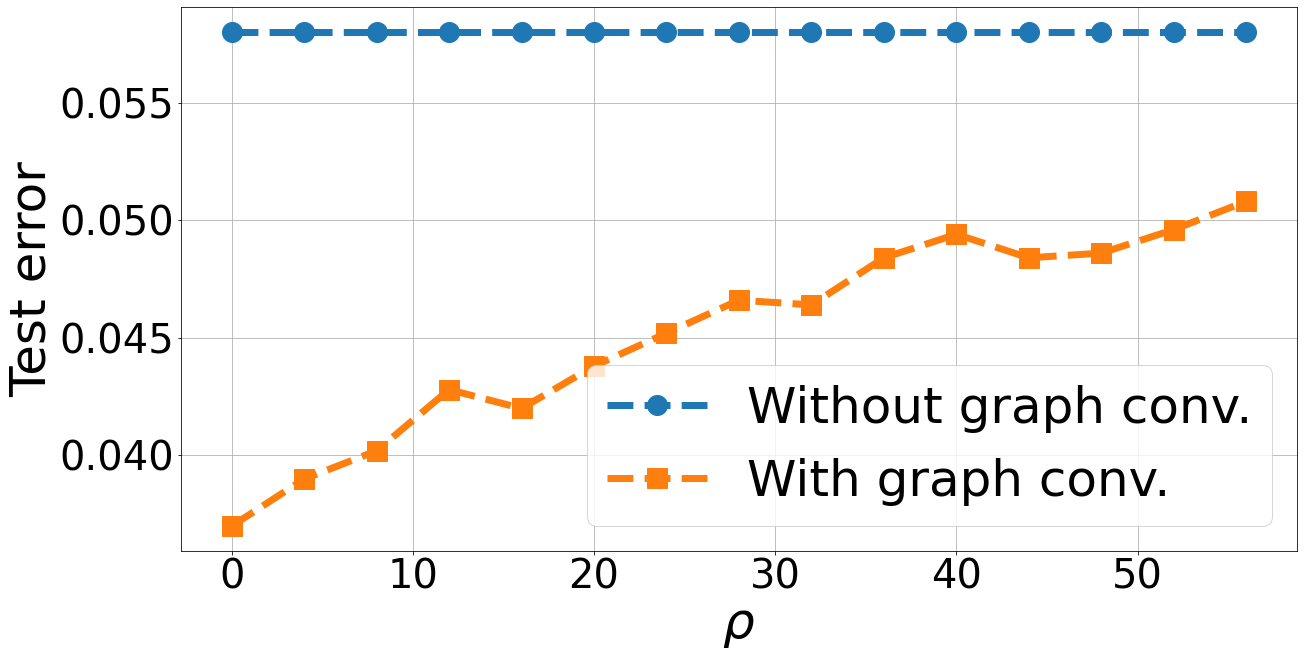

In [10]:
data = dataset.data
n_classes = data.y.numpy().max()+1
all_results, x_axis = generate_data(data, data.train_mask, data.test_mask, lambda_=1.0e-6, factor=60, step_multiplier=4, n_classes=n_classes)
plot_(all_results,x_axis,name,n_classes)

## PubMed

In [11]:
dataset = Planetoid(root='data/PubMed/', name='PubMed')
name = 'PubMed'

Processing...
Done!


class: A  n:  19717  d:  500  d(mu,nu):  0.109168574  alpha:  0.0025618035096708082  beta:  0.004874482086278333
/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
class: B  n:  19717  d:  500  d(mu,nu):  0.0729683  alpha:  0.0033394556687259976  beta:  0.002584313218762114
class: C  n:  19717  d:  500  d(mu,nu):  0.07037629  alpha:  0.0033778078027360244  beta:  0.0025396825396825397
Plot for class:  A


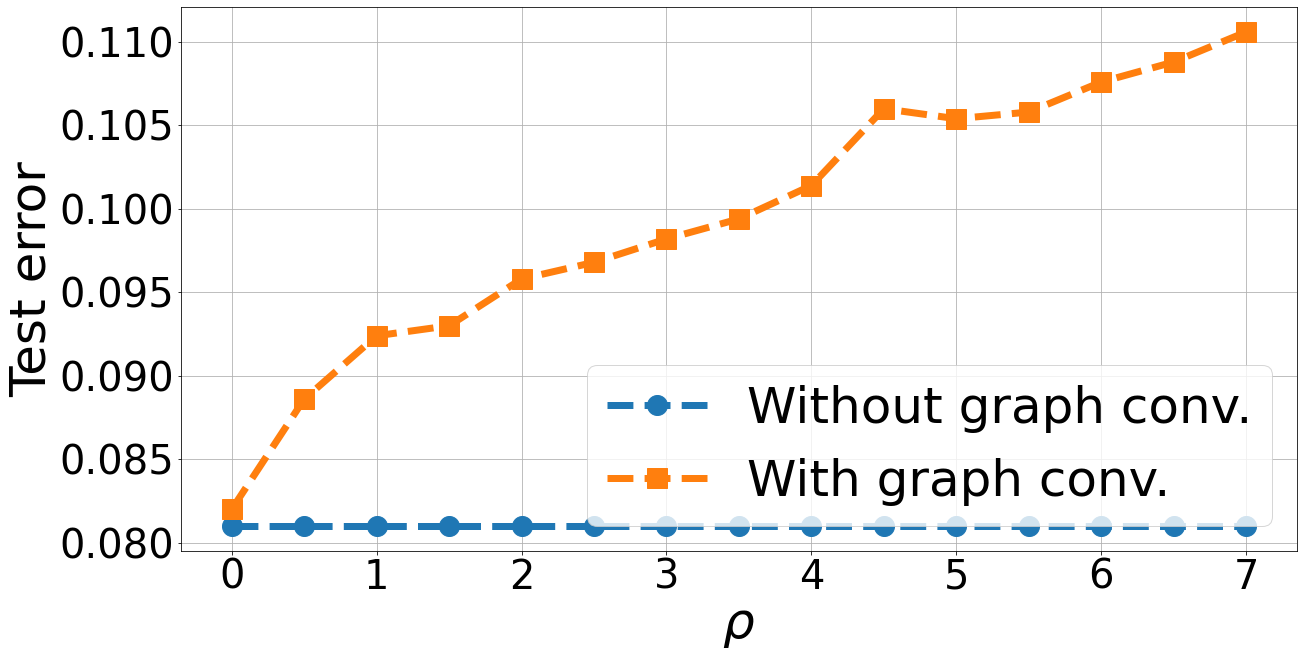

Plot for class:  B


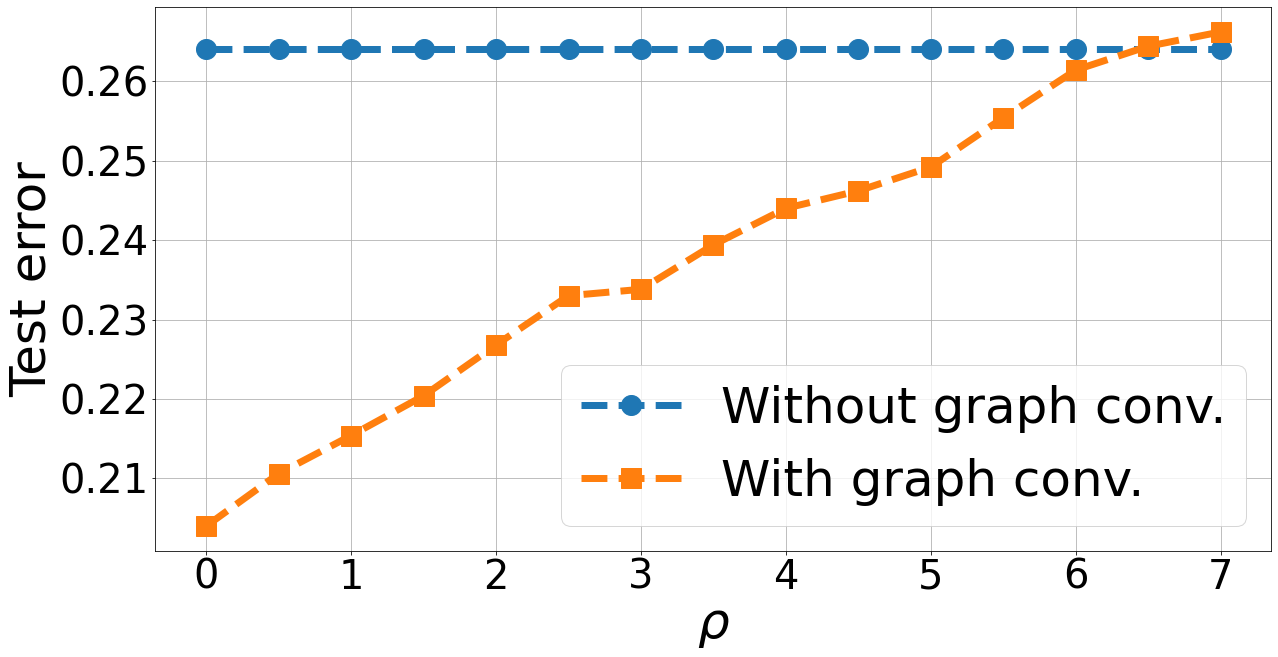

Plot for class:  C


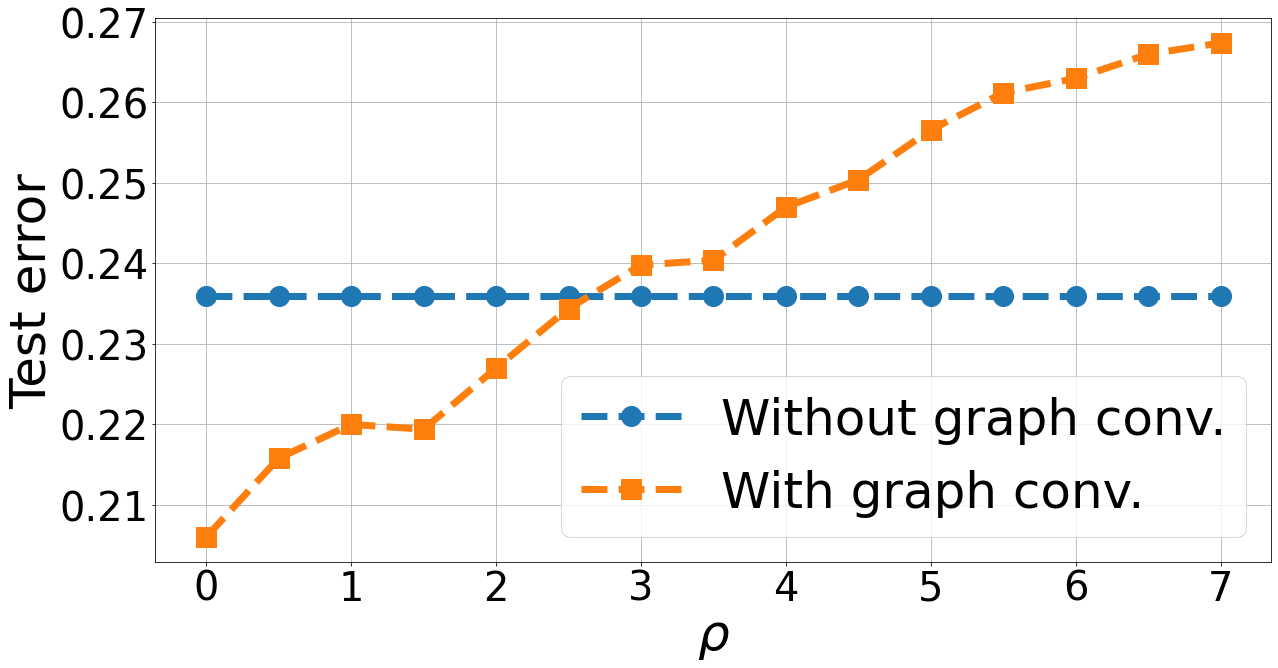

In [12]:
data = dataset.data
n_classes = data.y.numpy().max()+1
all_results, x_axis = generate_data(data, data.train_mask, data.test_mask, lambda_=1.0e-6, factor=7.2, step_multiplier=0.5, n_classes=n_classes)
plot_(all_results,x_axis,name,n_classes)

## WikipediaNetworks

In [13]:
from torch_geometric.datasets import WikipediaNetwork
dataset = WikipediaNetwork(root='data/WikipediaNetwork/', name='Chameleon')
name = 'WikipediaNetwork'

Processing...
Done!


class: A  n:  2277  d:  2325  d(mu,nu):  0.36127153  alpha:  0.47611202635914335  beta:  0.4934210526315789
/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
class: B  n:  2277  d:  2325  d(mu,nu):  0.3014668  alpha:  0.4799119427627958  beta:  0.4782608695652174
class: C  n:  2277  d:  2325  d(mu,nu):  0.21406822  alpha:  0.4791666666666667  beta:  0.48123620309050774
class: D  n:  2277  d:  2325  d(mu,nu):  0.42989865  alpha:  0.484624145785877  beta:  0.46257197696737046
class: E  n:  2277  d:  2325  d(mu,nu):  0.5298623  alpha:  0.4783068783068783  beta:  0.48578811369509045
Plot for class:  A


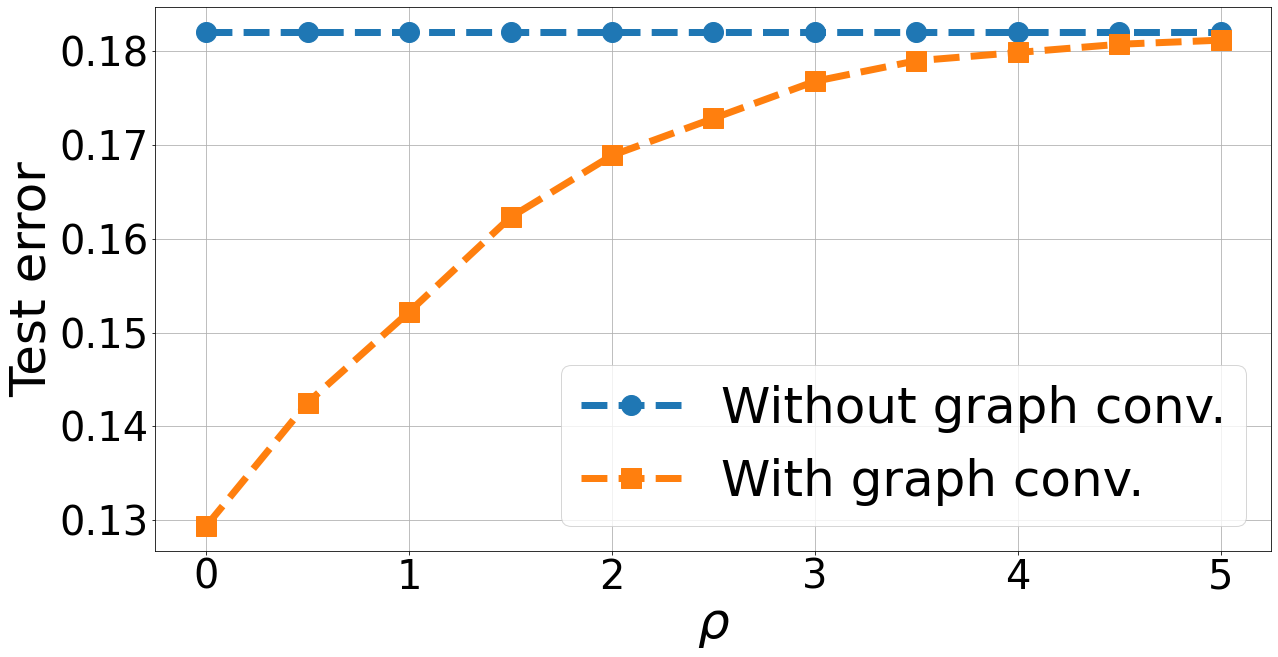

Plot for class:  B


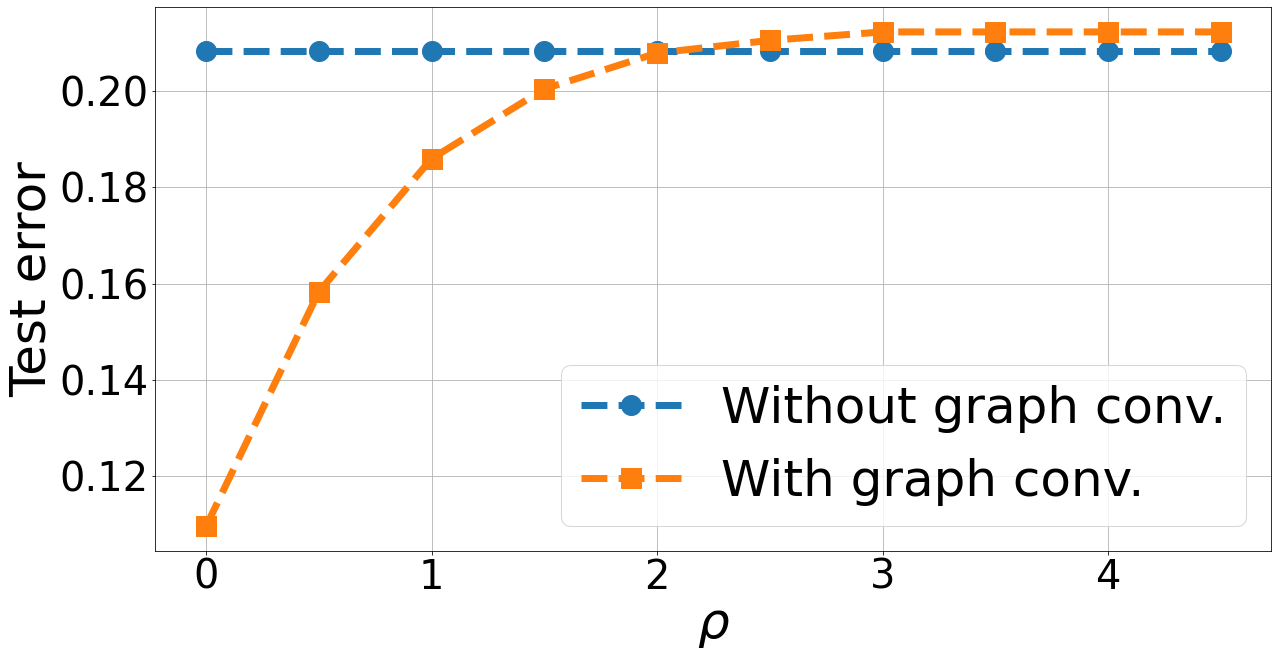

Plot for class:  C


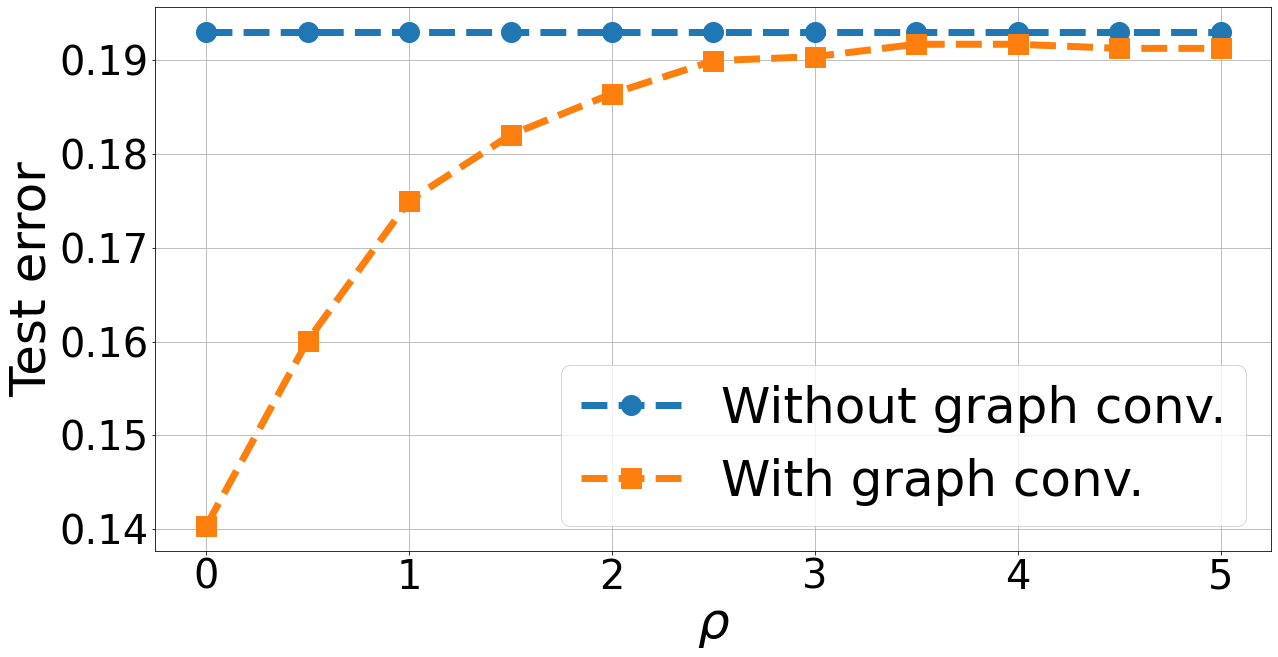

Plot for class:  D


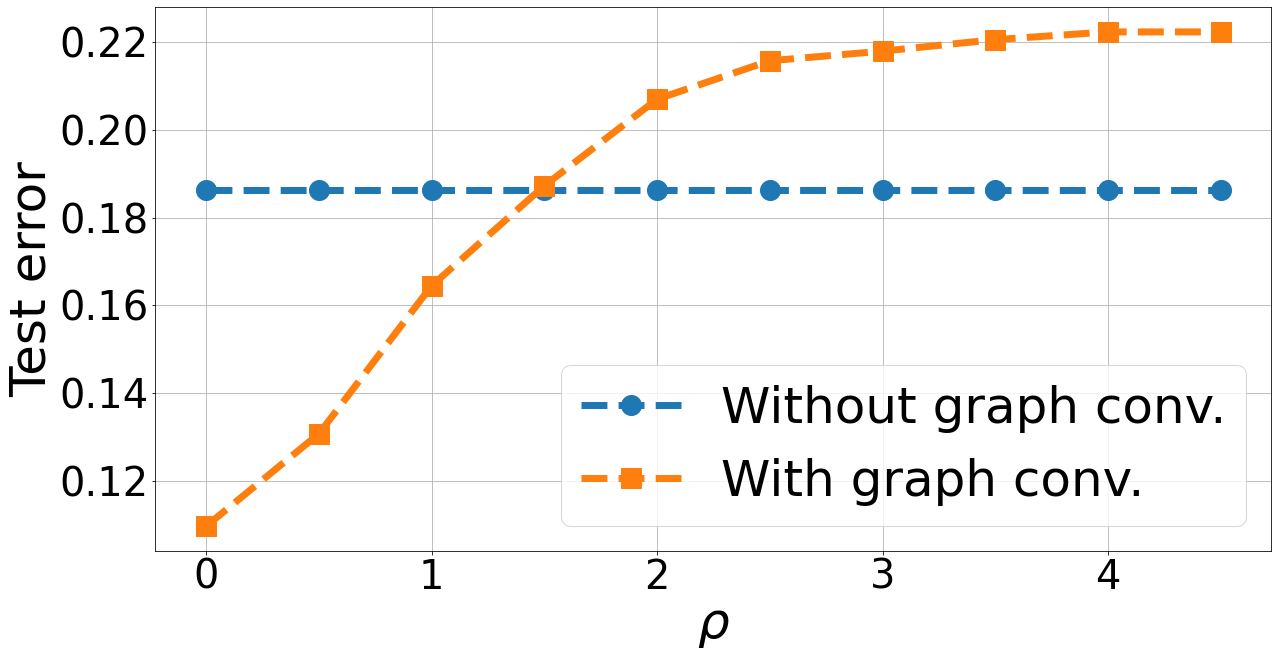

Plot for class:  E


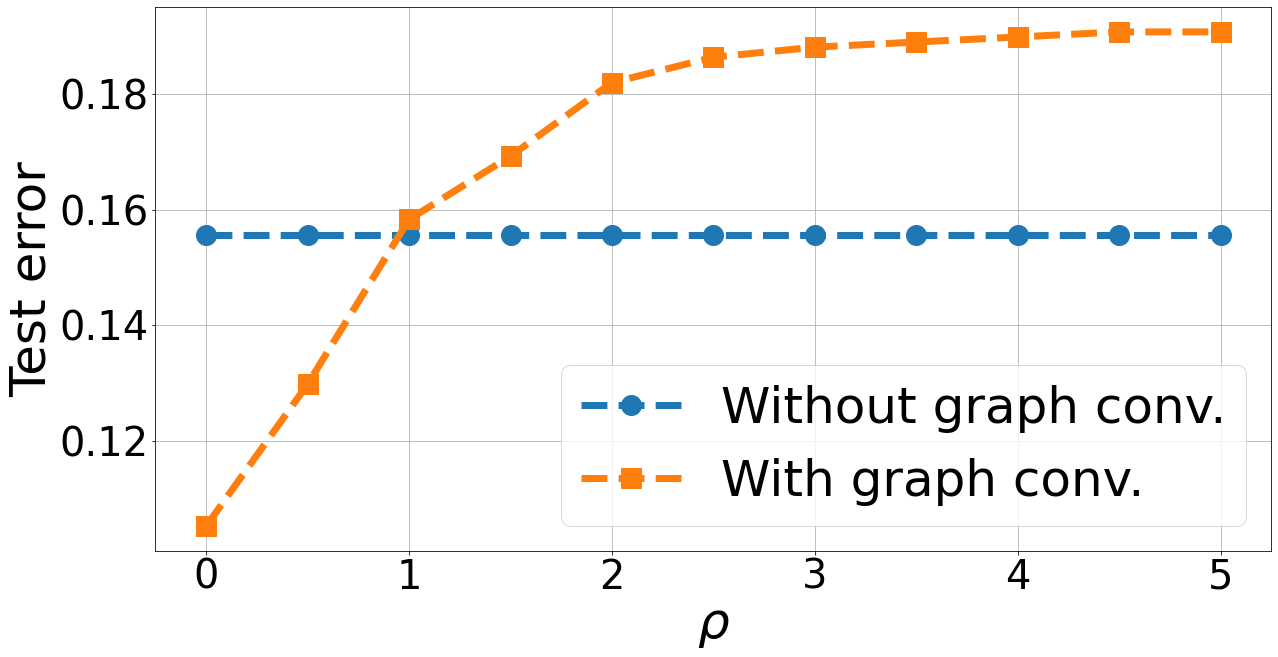

In [14]:
data = dataset.data
n_classes = int(data.y.numpy().max())+1
all_results, x_axis = generate_data(data, data.train_mask[:,0].numpy(), data.test_mask[:,0].numpy(), lambda_=1.0e-3, factor=5, step_multiplier=0.5, n_classes=n_classes)
plot_(all_results,x_axis,name,n_classes)